import os
import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

def ignore_warn(*args, **kwargs):
    pass

warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

In [11]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import datasets, svm
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.ensemble import RandomForestClassifier
import sklearn
import seaborn as sns

In [4]:
df_train = pd.read_csv("wine_train.csv")
df_test = pd.read_csv("wine_test.csv")

In [5]:
def remapping_target_class(base_class):
    mapping = {
        3 : 0,
        4 : 1,
        5 : 2,
        6 : 3,
        7 : 4,
        8 : 5,
        9 : 6
    }
    return mapping[base_class]



def restore_target_class(classes):
    target_map=[3,4,5,6,7,8,9]
    return target_map[classes]

In [6]:
df_train['quality'].value_counts()

6    2410
5    1793
7     910
4     184
8     170
3      25
9       5
Name: quality, dtype: int64

In [12]:
X = df_train[list(set(df_train.columns)-set(['quality']))]
X = pd.get_dummies(X, columns=["type"])
y = df_train['quality']
X, y = shuffle(X, y, random_state=0)

ss = StandardScaler()
sm = SMOTE(k_neighbors=4,random_state=42)

scaled_X = pd.DataFrame(columns=X.columns,data=ss.fit_transform(X))
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state=1)
X_train, Y_train = sm.fit_resample(X_train, Y_train)

In [14]:
Y_train = Y_train.apply(remapping_target_class)

In [15]:
Y_train.value_counts()

6    1676
5    1676
4    1676
3    1676
2    1676
1    1676
0    1676
Name: quality, dtype: int64

In [16]:
clf_sk = LogisticRegression(C=1e10, max_iter=500, solver="sag", tol=1e-10, penalty='l2')
clf_sk.fit(X_train, Y_train)

LogisticRegression(C=10000000000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=500, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='sag', tol=1e-10, verbose=0,
                   warm_start=False)

In [17]:
acc_train = accuracy_score(Y_train, clf_sk.predict(X_train))
predict_list = [restore_target_class(x) for x in list(clf_sk.predict(X_test))] 
acc_test = accuracy_score(Y_test, predict_list)

In [18]:
print("acc_train: "+ str(acc_train) + "   acc_test: "+ str(acc_test))

acc_train: 0.4241391067166724   acc_test: 0.23333333333333334


In [19]:
X_train

,alcohol,sulphates,chlorides,density,pH,total.sulfur.dioxide,fixed.acidity,volatile.acidity,residual.sugar,citric.acid,free.sulfur.dioxide,type_R,type_W
0,10.800000,0.490000,0.029000,0.993260,3.080000,131.000000,6.900000,0.220000,6.300000,0.310000,41.000000,0,1
1,10.000000,0.540000,0.047000,0.994800,3.200000,129.000000,8.000000,0.240000,1.500000,0.360000,17.000000,0,1
2,10.800000,0.620000,0.089000,0.992300,3.490000,143.000000,6.000000,0.180000,1.500000,0.270000,40.000000,0,1
3,10.500000,0.450000,0.048000,0.993300,3.250000,131.000000,7.200000,0.240000,1.600000,0.300000,27.000000,0,1
4,10.500000,0.770000,0.039000,0.992600,3.140000,136.000000,7.300000,0.155000,1.300000,0.490000,34.000000,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11727,10.535005,0.470125,0.034055,0.996504,3.214176,121.367401,8.931244,0.276075,9.992477,0.439200,27.729990,0,1
11728,12.707480,0.448878,0.031519,0.990420,3.326683,125.513774,7.244390,0.250374,2.103740,0.427431,29.074804,0,1
11729,12.571746,0.469238,0.031179,0.990505,3.296143,134.336518,7.346191,0.243587,2.035873,0.383317,27.717459,0,1
11730,12.511729,0.478241,0.031029,0.990543,3.282639,138.237590,7.391203,0.240586,2.005865,0.363812,27.117294,0,1


In [20]:
normal_rf_score=0
for i in range(50):
    clf = RandomForestClassifier()
    clf.fit(X_train, Y_train)
    predict_list_rf = [restore_target_class(x) for x in list(clf.predict(X_test))] 
    normal_rf_score+=accuracy_score(Y_test, predict_list_rf)
# 予測して精度を確認する

print(normal_rf_score/50)

0.5991757575757576


In [21]:
balanced_rf_score=0
for i in range(50):
    clf = RandomForestClassifier(class_weight='balanced')
    clf.fit(X_train, Y_train)
    predict_list_rf = [restore_target_class(x) for x in list(clf.predict(X_test))] 
    balanced_rf_score+=accuracy_score(Y_test, predict_list_rf)
# 予測して精度を確認する

print(balanced_rf_score/50)

0.6005454545454546


In [22]:
# confusion_matrixの確認
sklearn.metrics.confusion_matrix(Y_test,predict_list_rf)

array([[  0,   1,   4,   4,   0,   0,   0],
       [  0,   9,  30,  17,   1,   0,   0],
       [  1,   6, 372, 145,   7,   0,   0],
       [  0,   1, 179, 499,  52,   2,   1],
       [  0,   1,  15, 136, 116,   4,   0],
       [  0,   0,   1,  20,  10,  16,   0],
       [  0,   0,   0,   0,   0,   0,   0]])

In [23]:
names = df_train.columns

In [24]:
clf.feature_importances_

array([0.10648579, 0.09068013, 0.08074605, 0.07765486, 0.10044267,
       0.09356228, 0.10654287, 0.06893847, 0.08179036, 0.07083698,
       0.11672683, 0.00157763, 0.00401508])

In [25]:
sorted(zip(map(lambda x: round(x, 4), clf.feature_importances_), names), 
             reverse=True)

[(0.1167, 'sulphates'),
 (0.1065, 'type'),
 (0.1065, 'free.sulfur.dioxide'),
 (0.1004, 'residual.sugar'),
 (0.0936, 'chlorides'),
 (0.0907, 'fixed.acidity'),
 (0.0818, 'density'),
 (0.0807, 'volatile.acidity'),
 (0.0777, 'citric.acid'),
 (0.0708, 'pH'),
 (0.0689, 'total.sulfur.dioxide'),
 (0.004, 'quality'),
 (0.0016, 'alcohol')]

In [26]:
# K近傍法
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
# k=6からはじめてみます。
# インスタンスを作ります。
knn = KNeighborsClassifier(n_neighbors = 1)

# 学習します。
knn.fit(X_train,Y_train)

# テストデータを予測します。
predict_list_knn = [restore_target_class(x) for x in list(knn.predict(X_test))] 

# 精度を調べてみましょう。
print(metrics.accuracy_score(Y_test,predict_list_knn))

0.5206060606060606


In [27]:
# kを変化させてみましょう。
k_range = range(1, 90)

accuracy = []

# 先ほどの計算を繰り返して見ましょう。
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, Y_train)
    predict_list_knn = [restore_target_class(x) for x in list(knn.predict(X_test))] 
    accuracy.append(metrics.accuracy_score(Y_test, predict_list_knn))

Text(0, 0.5, 'Testing Accuracy')

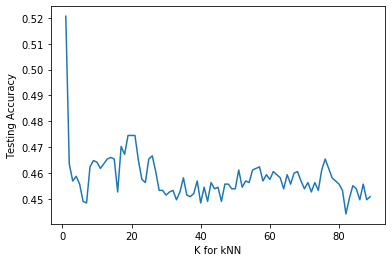

In [28]:
plt.plot(k_range, accuracy)
plt.xlabel('K for kNN')
plt.ylabel('Testing Accuracy')